In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
import numpy as np
import cmdstanpy
#cmdstanpy.install_cmdstan(compiler=True)
import os
from tqdm import tqdm

In [3]:
with open('data/simulated/data.pkl', "rb") as f:  # Python 3: open(..., 'rb')
    sujetos, delitos = pickle.load(f)

In [4]:
# One-hot para las variables categoricas de los nodos
df_sujetos = pd.DataFrame.from_dict(sujetos, orient="index")
sdummies = pd.get_dummies(df_sujetos["comuna"], dtype=int, drop_first=True)
df_sujetos = pd.concat([df_sujetos, sdummies], axis=1)
df_sujetos.drop(columns="comuna", inplace=True)
sujetos = df_sujetos.to_dict(orient="index")

# One-hot para las variables categoricas de los enlaces
attr_delitos = {i:delitos[i][1] for i in delitos.keys()}
nodes_delitos = {i:delitos[i][0] for i in delitos.keys()}

df_delitos = pd.DataFrame.from_dict(attr_delitos, orient="index")
cat_cols = ["lugar"]
for col in cat_cols:
    ddummies = pd.get_dummies(df_delitos[col], dtype=int, drop_first=True)
    df_delitos = pd.concat([df_delitos, ddummies], axis=1)
    df_delitos.drop(columns=col, inplace=True)
df_delitos["tipo_id"] = df_delitos["tipo"].factorize()[0]+1
attr_delitos = df_delitos.to_dict(orient="index")


In [5]:
categorical = ["comuna"]
non_categorical = ["edad"]

y = []
u = []
w = []
i = []
j = []
q = []

n_attr = len(list(sujetos[next(iter(sujetos))].values()))

for delito in attr_delitos.keys():
    S = nodes_delitos[delito]
    for sujeto in sujetos.keys():

        S_ = S.copy()

        if sujeto in S: 
            y_ = 1 
            S_.remove(sujeto)
        else: y_ = 0

        group_features = {p:sujetos[p] for p in S_}
        if len(group_features) != 0:
            group_features_matrix = [list(value.values()) for key, value in group_features.items()]
        else:
            group_features_matrix = [n_attr * [0]]
        
        u_ = list(sujetos[sujeto].values())
        w_ = list(attr_delitos[delito].values())[1:-1]
        i_ = sujeto
        j_ = attr_delitos[delito]["tipo_id"]

        q_ = np.array(list(group_features_matrix))
        q_ = np.dot(np.ones(len(q_)), q_)
        q_ = np.concatenate((np.array([len(S_)]), q_))
        q_ = np.concatenate((q_, q_*q_)).astype(int).tolist()

        
        y.append(y_)
        u.append(u_)
        w.append(w_)
        i.append(i_)
        j.append(j_)
        q.append(q_)


N = len(y)
U = len(u[0])
W = len(w[0])
Q = len(q[0])
I = len(sujetos)
J = len(pd.unique(np.array(j)))
x = [list(sujetos[i].values()) for i in sujetos.keys()]

cmdstanpy.write_stan_json("stan_models/simulated_data.json", {"N":N, "U":U, "W":W, "I":I, "J":J, "u":u, "x":x, "w":w, "q":q, "Q":Q, "i":i, "j":j, "y":y})

In [15]:
stan_model = cmdstanpy.CmdStanModel(stan_file=os.path.join("stan_models",'logit.stan'), force_compile=True
                                    )

fit = stan_model.sample(
    data="stan_models/simulated_data.json",
    chains=4,
    iter_sampling=1000,
    iter_warmup=500, 
    seed=12345, #show_console=True
)

19:13:27 - cmdstanpy - INFO - compiling stan file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit.stan to exe file C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit.exe
19:13:45 - cmdstanpy - INFO - compiled model executable: C:\Users\dimot\Documents\Universidad\tesis\tesis\stan_models\logit.exe
19:13:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:19 - cmdstanpy - INFO - CmdStan done processing.


19:15:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 divergent transitions (0.5%)
	Chain 2 had 1 divergent transitions (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [16]:
print(fit.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
6 of 1000 (0.60%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  beta[7,1], beta[8,1], beta[9,1], beta[7,2], beta[8,2], beta[9,2], beta[7,3], beta[8,3], beta[9,3], beta[7,4], beta[8,4], beta[9,4], theta1[1], theta1[2], theta2[1], theta2[2], lambda[5,1], lambda[6,1], lambda[8,1], lambda[9,1], lambda[5,2], lambda[8,2], lambda[9,2], lambda[5,3], lambda[6,3], lambda[8,3], lambda[9,3], lambda[5,4], lambda[8,4], lambda[9,4], l

In [103]:
fit.save_csvfiles("stan_models/sim_fitted_logit")

In [95]:
sujetos

{1: {'edad': 16, 'la pintana': 1},
 2: {'edad': 15, 'la pintana': 1},
 3: {'edad': 18, 'la pintana': 1},
 4: {'edad': 17, 'la pintana': 1},
 5: {'edad': 25, 'la pintana': 0},
 6: {'edad': 30, 'la pintana': 0},
 7: {'edad': 37, 'la pintana': 0},
 8: {'edad': 23, 'la pintana': 1},
 9: {'edad': 25, 'la pintana': 1},
 10: {'edad': 20, 'la pintana': 1}}

In [41]:
attr_delitos

{1: {'tipo': 'encerrona',
  'agresión': 1,
  'la granja': 1,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 2: {'tipo': 'encerrona',
  'agresión': 0,
  'la granja': 0,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 3: {'tipo': 'encerrona',
  'agresión': 1,
  'la granja': 0,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 4: {'tipo': 'encerrona',
  'agresión': 1,
  'la granja': 1,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 5: {'tipo': 'encerrona',
  'agresión': 1,
  'la granja': 1,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 6: {'tipo': 'encerrona',
  'agresión': 1,
  'la granja': 1,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 7: {'tipo': 'encerrona',
  'agresión': 0,
  'la granja': 0,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 8: {'tipo': 'encerrona',
  'agresión': 1,
  'la granja': 0,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 9: {'tipo': 'encerrona',
  'agresión': 1,
  'la granja': 1,
  'la pintana': 0,
  'macul': 0,
  'tipo_id': 1},
 

<Axes: ylabel='Count'>

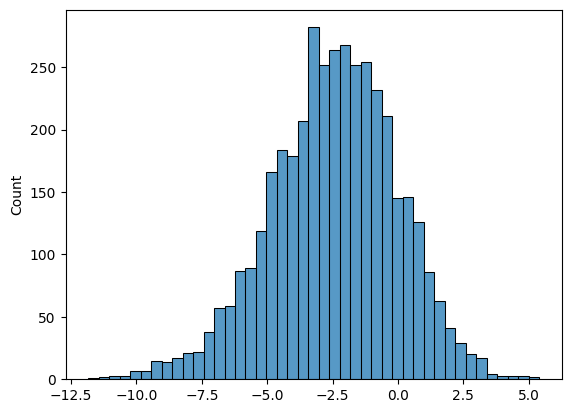

In [14]:
sns.histplot(fit.stan_variables()["beta"].T[0][5])

In [107]:
import random
from scipy.special import expit
# Obtenemos las características del delito / compra
crime_type = 0
z_j = [1,0,1,0]

# Definimos el grupo inicial
group = []
n_attr = len(list(sujetos[next(iter(sujetos))].values())) # Anotamos la cantidad de atributos de un sujeto para cuando el grupo sea vacío.

# Definimos las características del grupo inicial
group_features = {p:sujetos[p] for p in group}
if len(group_features) != 0:
   group_features_matrix = [list(value.values()) for key, value in group_features.items()]
else:
   group_features_matrix = [n_attr * [0]]

q = np.array(list(group_features_matrix))
q = np.dot(np.ones(len(q)), q)

N_iter = 50000

samples = []
n_muestras = len(fit.stan_variables()[next(iter(fit.stan_variables()))])

i_index = list(sujetos.keys())
I = len(sujetos)

for n in tqdm(range(N_iter)):
   sample = random.sample(range(n_muestras), 1)[0]

   gamma = fit.stan_variables()["gamma"][sample]
   betas = fit.stan_variables()["beta"][sample]
   lambdas = fit.stan_variables()["lambda"][sample]

   i_order = random.sample(i_index, I)

   for s in i_order:
      change_flag = False
      u_i = np.array(list(sujetos[s].values()))
      beta = betas[s-1]
      lambd = lambdas[s-1]

      node_propension = np.dot(u_i, gamma)
      link_preference = np.dot(z_j, beta)
      group_preference = np.dot(q, lambd)
      util = node_propension + link_preference + group_preference
      p = expit(util)
      
      if (random.random() < p):
         if (s not in group): # si el resultado es positivo, y no está en el grupo
            group.append(s)
            change_flag = True
      else:
         if s in group:
            group.remove(s)
            change_flag = True

      if change_flag: # Si cambió un miembro del grupo, tenemos que recalcular q
         group_features = {p:sujetos[p] for p in group}
         if len(group_features) != 0:
            group_features_matrix = [list(value.values()) for key, value in group_features.items()]
         else:
            group_features_matrix = [n_attr * [0]]

         q = np.array(list(group_features_matrix))
         q = np.dot(np.ones(len(q)), q)

   # Terminamos la iteración por los sujetos de la red
   if n > 3000:
      samples.append(group.copy())



      

100%|██████████| 50000/50000 [00:05<00:00, 9411.65it/s]


In [109]:
import numpy as np
import pandas as pd

# samples: lista de listas con los grupos en cada iteración
# i_index: lista de todos los IDs de sujetos posibles

# 1) Número total de iteraciones
N = len(samples)

# 2) Contar cuántas veces aparece cada sujeto
marginal_counts = {s: 0 for s in i_index}
for grp in samples:
    for s in grp:
        marginal_counts[s] += 1

# 3) Crear DataFrame de probabilidades marginales
df = pd.DataFrame({
    'subject': list(marginal_counts.keys()),
    'marginal_probability': [count / N for count in marginal_counts.values()]
})

# 4) Ordenar de mayor a menor
df = df.sort_values('marginal_probability', ascending=False).reset_index(drop=True)

# 5) Mostrar las top-k (p. ej. top 10)
k = 10
print(df.head(k))


   subject  marginal_probability
0        1              0.727228
1        3              0.583672
2        2              0.374519
3        4              0.312539
4       10              0.277857
5        8              0.097960
6        5              0.090172
7        9              0.071044
8        6              0.044192
9        7              0.036873


<Axes: ylabel='Count'>

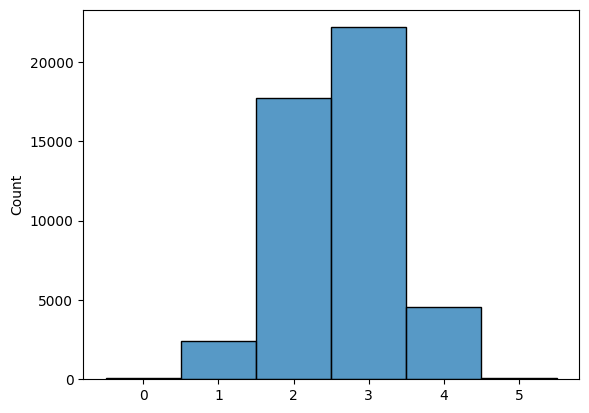

In [111]:
pos = {s: idx for idx, s in enumerate(i_index)}

# 2) Creamos la matriz binaria: rows=iter, cols=subjects
trace = np.zeros((len(samples), len(i_index)), dtype=int)

for t, grp in enumerate(samples):
    for s in grp:
        trace[t, pos[s]] = 1
sizes = []
for t in trace:
    sizes.append(t.sum())

sns.histplot(sizes, discrete=True)

In [112]:
samples_str = [str(sample) for sample in samples]
samples_df = pd.DataFrame()
samples_df["sample"] = samples_str

In [132]:
top_samples = samples_df.groupby("sample").agg({"sample":"count"}).rename(columns={"sample":"count"})
top_samples.sort_values(by='count', ascending=False).head(10)

,count
sample,
"[1, 3]",2704
"[1, 3, 2]",1612
"[3, 1]",1418
"[1, 3, 4]",1315
"[1, 2]",1311
"[1, 10]",1234
"[1, 4]",1227
"[1, 2, 3]",1182
"[1, 3, 10]",1169


In [130]:
top_samples